In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [4]:
CSV_PATH = 'solarpowergeneration.csv'
# Load
df = pd.read_csv(CSV_PATH)
print('Shape:', df.shape)
display(df.head())

Shape: (2920, 10)


,distance-to-solar-noon,temperature,wind-direction,wind-speed,sky-cover,visibility,humidity,average-wind-speed-(period),average-pressure-(period),power-generated
0,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


In [6]:
# Info & dtypes
print(df.info())

# Duplicate rows
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")

# Descriptive stats
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   distance-to-solar-noon       2920 non-null   float64
 1   temperature                  2920 non-null   int64  
 2   wind-direction               2920 non-null   int64  
 3   wind-speed                   2920 non-null   float64
 4   sky-cover                    2920 non-null   int64  
 5   visibility                   2920 non-null   float64
 6   humidity                     2920 non-null   int64  
 7   average-wind-speed-(period)  2919 non-null   float64
 8   average-pressure-(period)    2920 non-null   float64
 9   power-generated              2920 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 228.3 KB
None
Duplicate rows: 0


,count,mean,std,min,25%,50%,75%,max
distance-to-solar-noon,2920.0,0.503294,0.298024,0.050401,0.243714,0.478957,0.739528,1.141361
temperature,2920.0,58.468493,6.841200,42.000000,53.000000,59.000000,63.000000,78.000000
wind-direction,2920.0,24.953425,6.915178,1.000000,25.000000,27.000000,29.000000,36.000000
wind-speed,2920.0,10.096986,4.838185,1.100000,6.600000,10.000000,13.100000,26.600000
sky-cover,2920.0,1.987671,1.411978,0.000000,1.000000,2.000000,3.000000,4.000000
visibility,2920.0,9.557705,1.383884,0.000000,10.000000,10.000000,10.000000,10.000000
humidity,2920.0,73.513699,15.077139,14.000000,65.000000,77.000000,84.000000,100.000000
average-wind-speed-(period),2919.0,10.129154,7.261547,0.000000,5.000000,9.000000,15.000000,40.000000
average-pressure-(period),2920.0,30.017760,0.142006,29.480000,29.920000,30.000000,30.110000,30.530000
power-generated,2920.0,6979.846233,10312.336413,0.000000,0.000000,404.000000,12723.500000,36580.000000


In [7]:
# Missing values
na_count = df.isnull().sum()
na_pct = (na_count / len(df)) * 100

missing_table = pd.DataFrame({'missing': na_count, 'missing_%': na_pct})
display(missing_table[missing_table['missing'] > 0].sort_values(by='missing_%', ascending=False))

,missing,missing_%
average-wind-speed-(period),1,0.034247


In [8]:
mean_wind_speed = df['average-wind-speed-(period)'].mean()
df['average-wind-speed-(period)'].fillna(mean_wind_speed, inplace=True)

# Verify that there are no more missing values
display(df.isnull().sum())

C:\Users\HP\AppData\Local\Temp\ipykernel_12712\2931908329.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['average-wind-speed-(period)'].fillna(mean_wind_speed, inplace=True)


distance-to-solar-noon         0
temperature                    0
wind-direction                 0
wind-speed                     0
sky-cover                      0
visibility                     0
humidity                       0
average-wind-speed-(period)    0
average-pressure-(period)      0
power-generated                0
dtype: int64

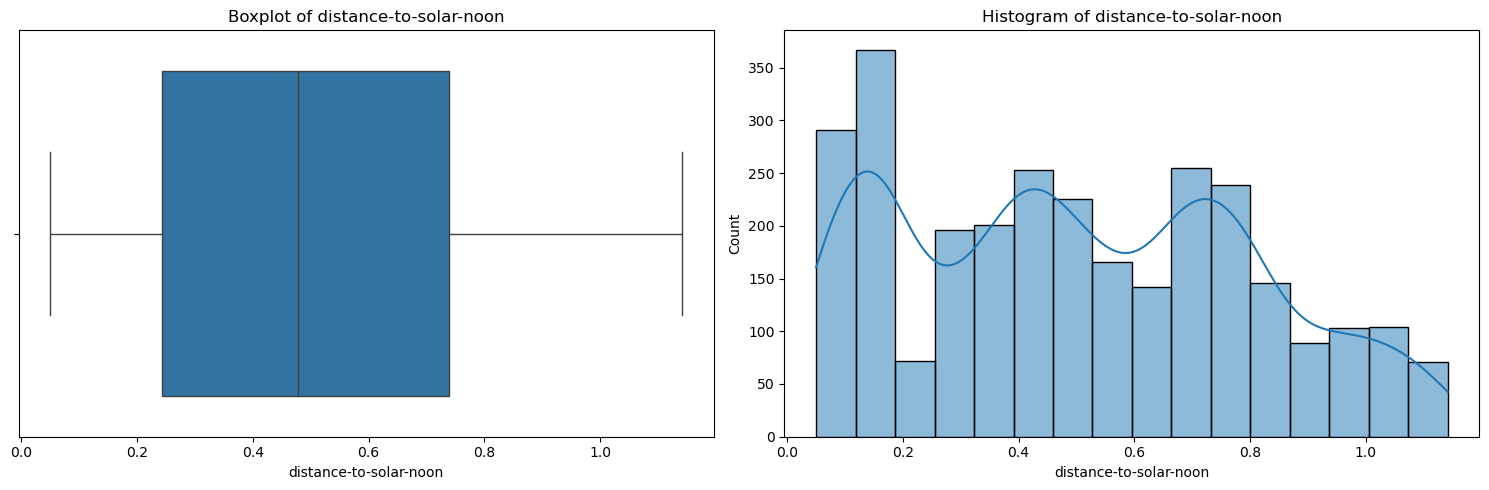

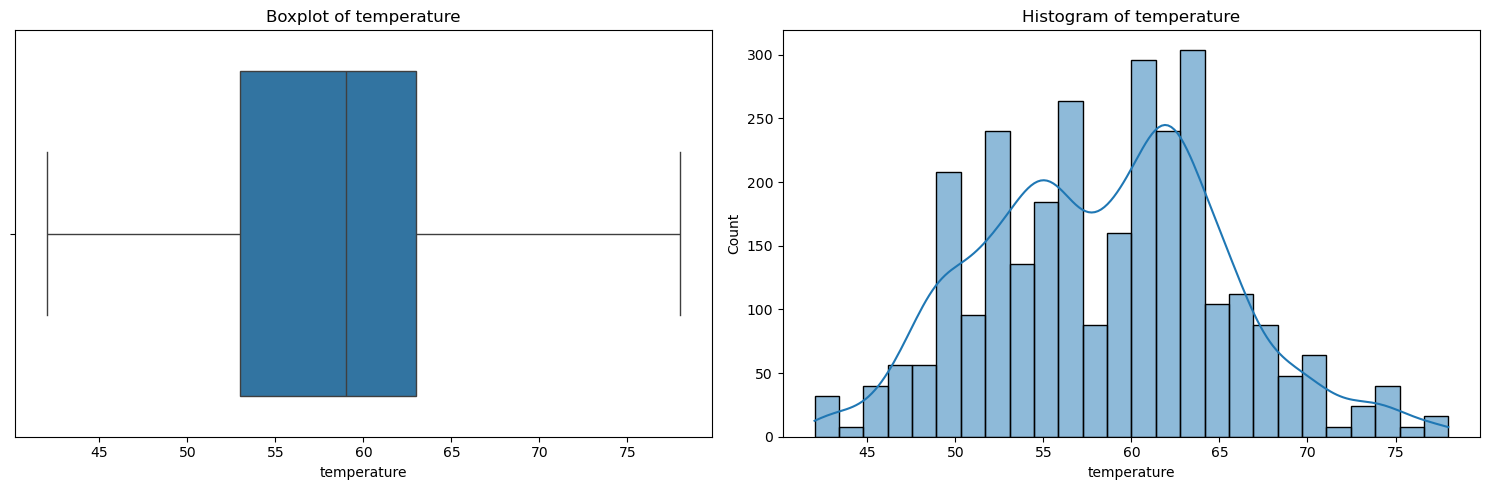

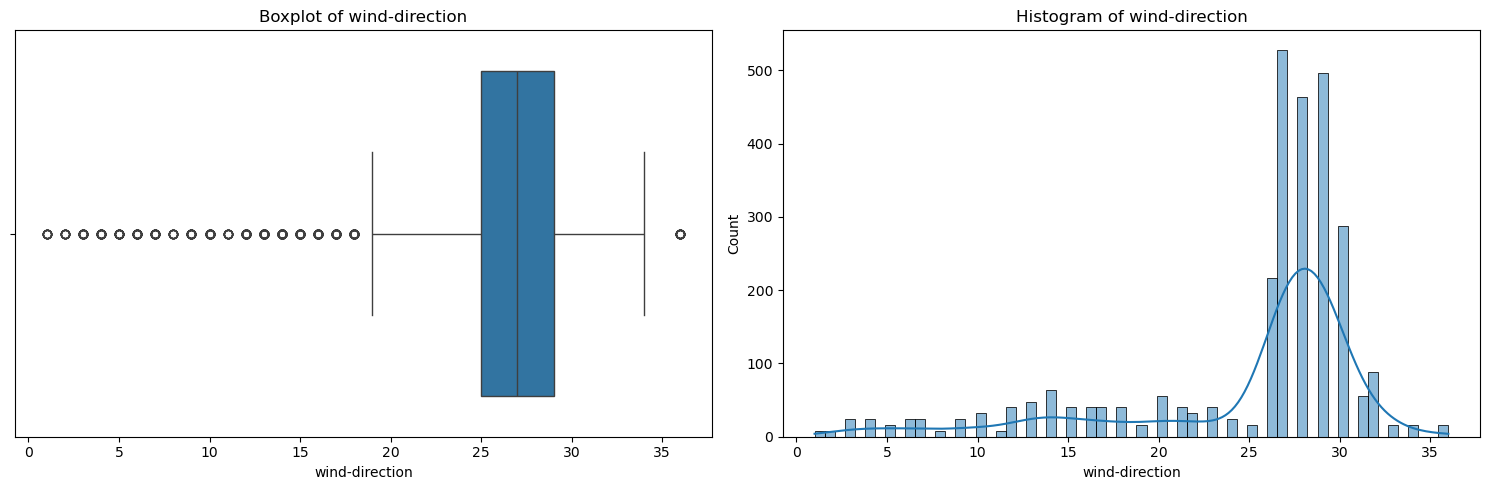

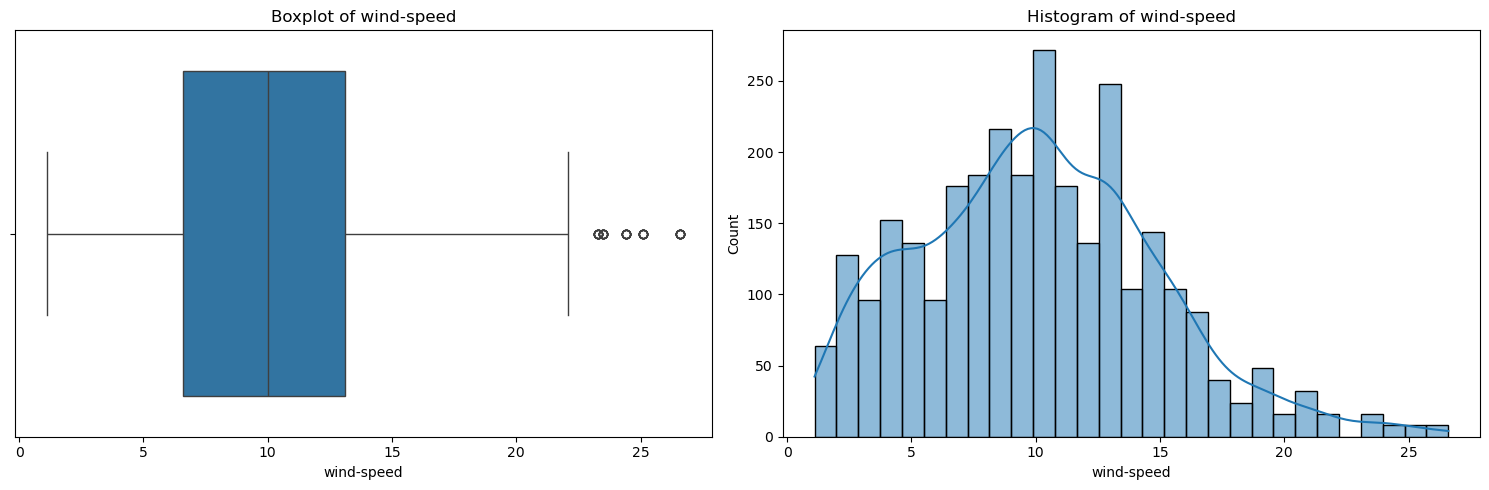

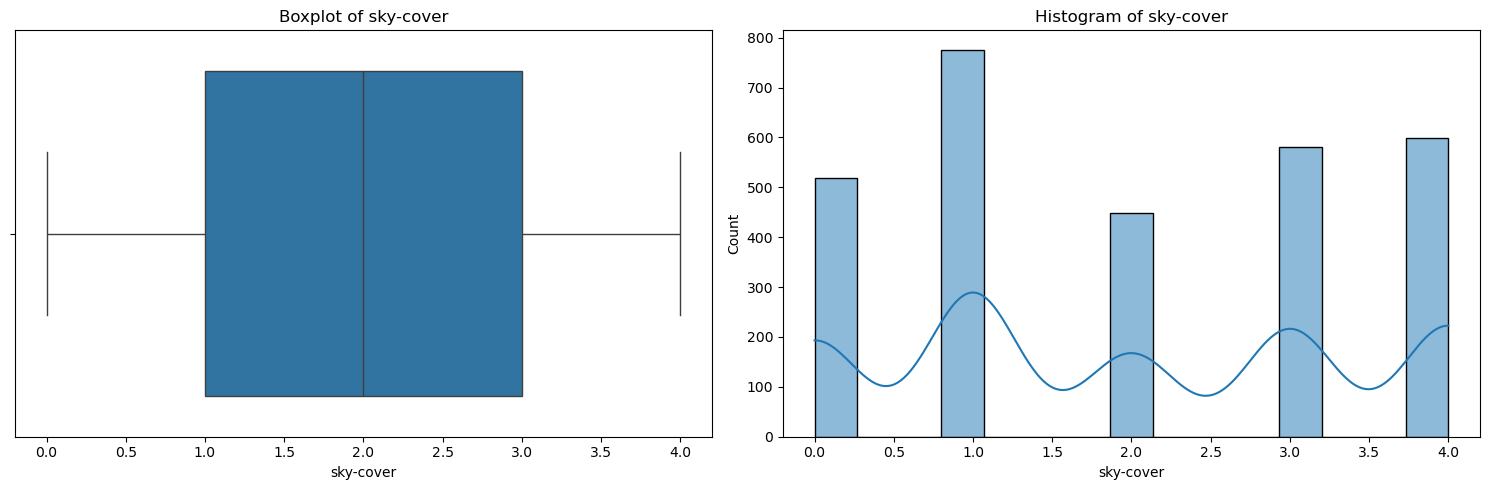

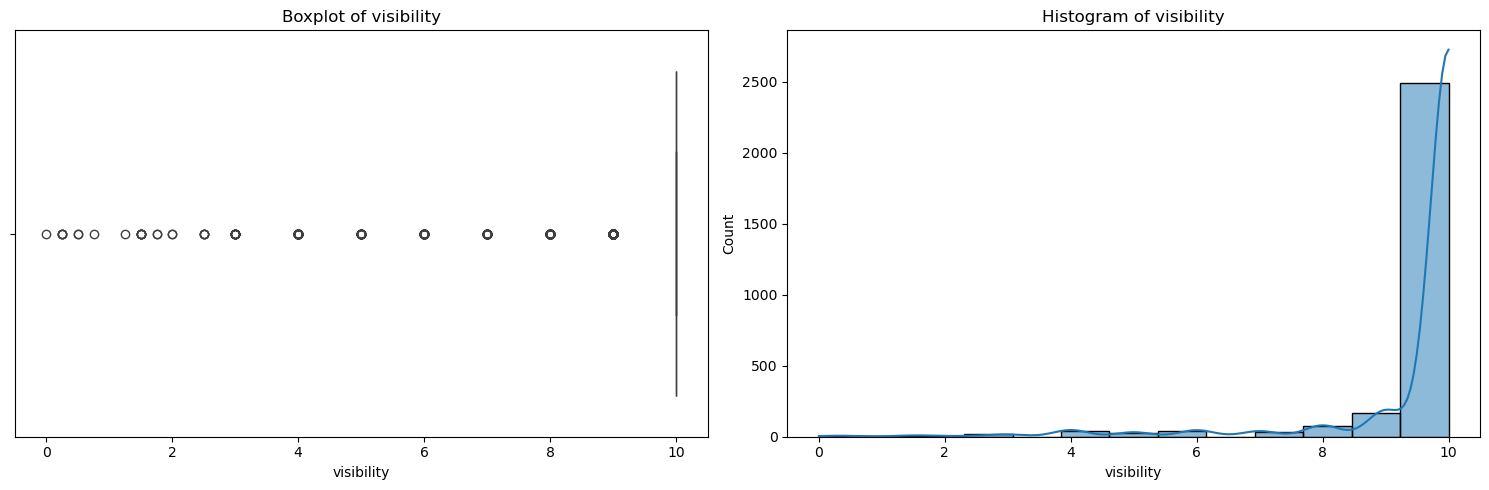

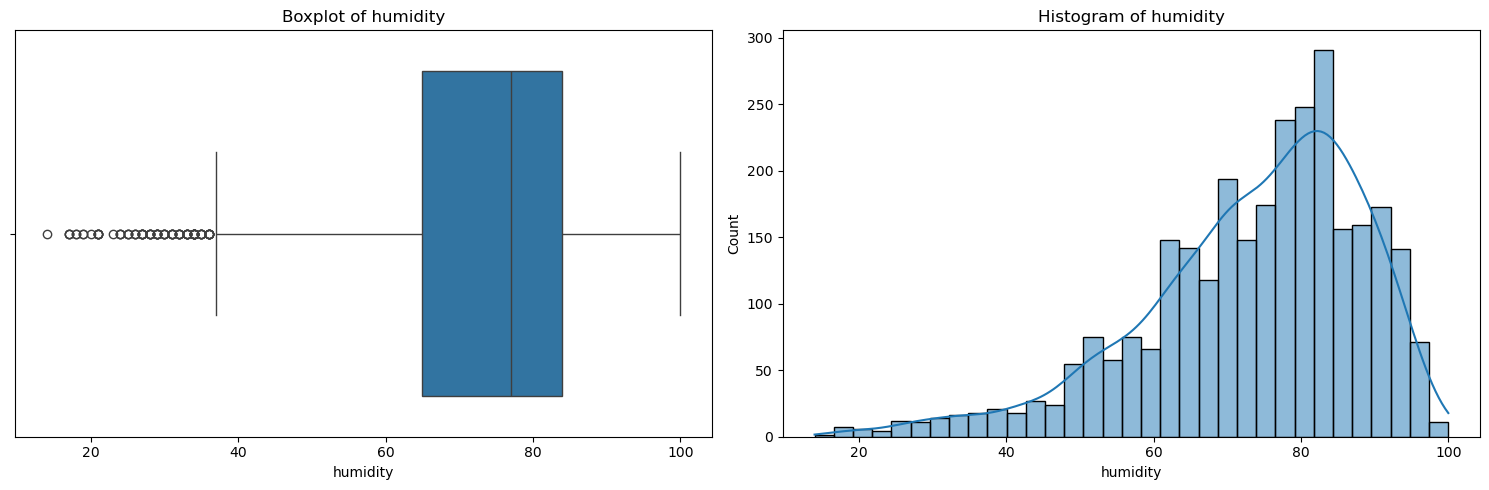

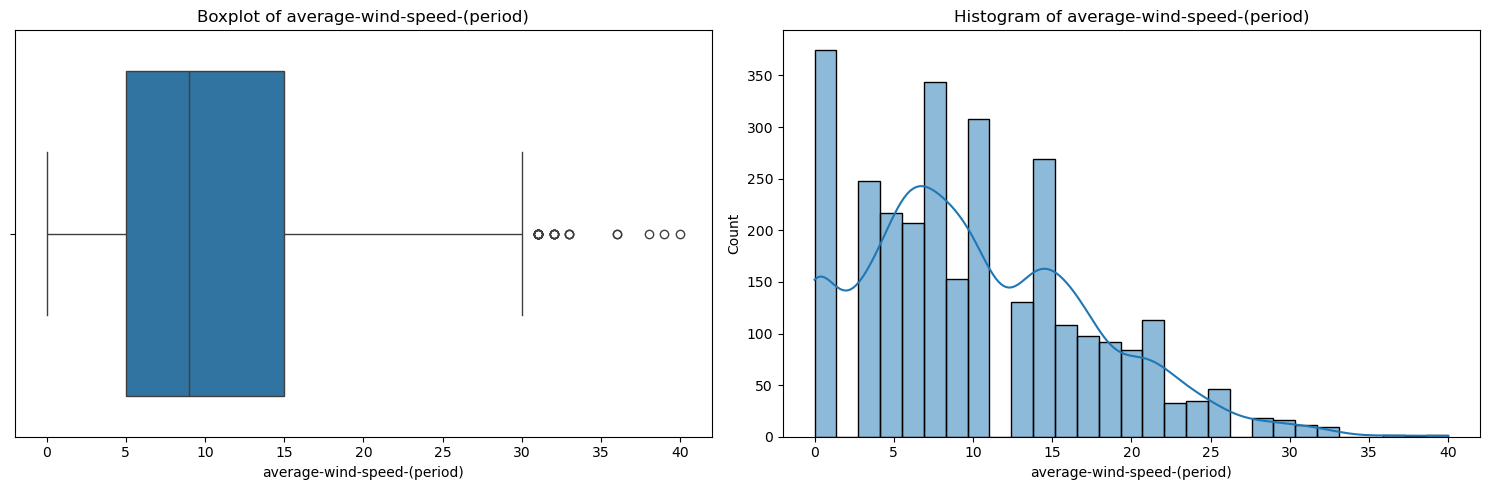

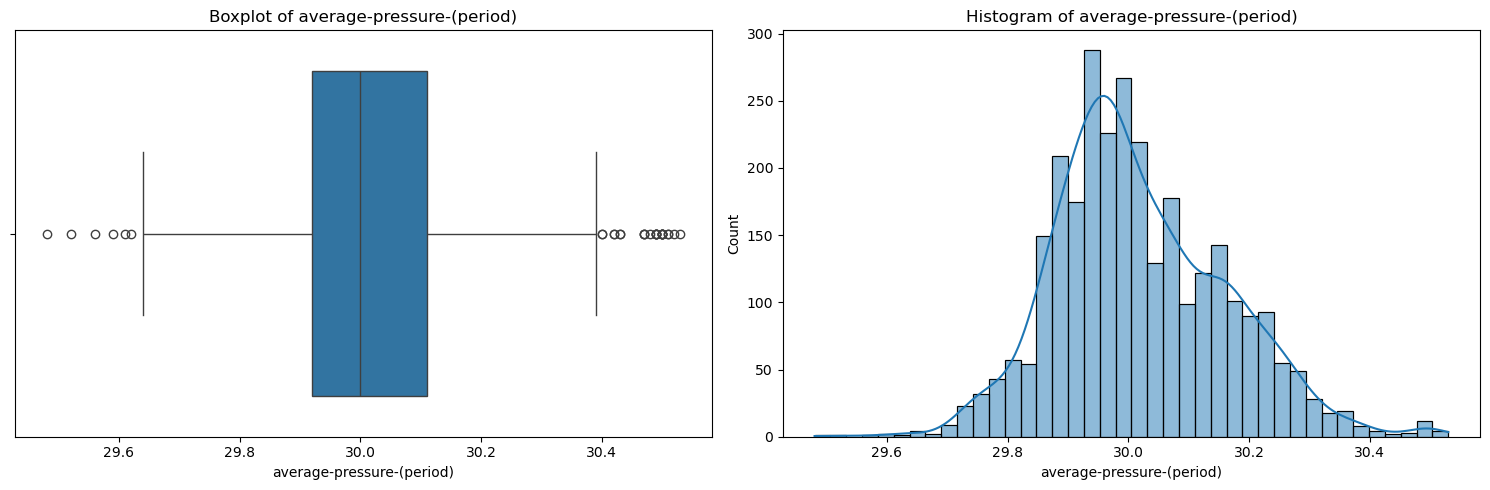

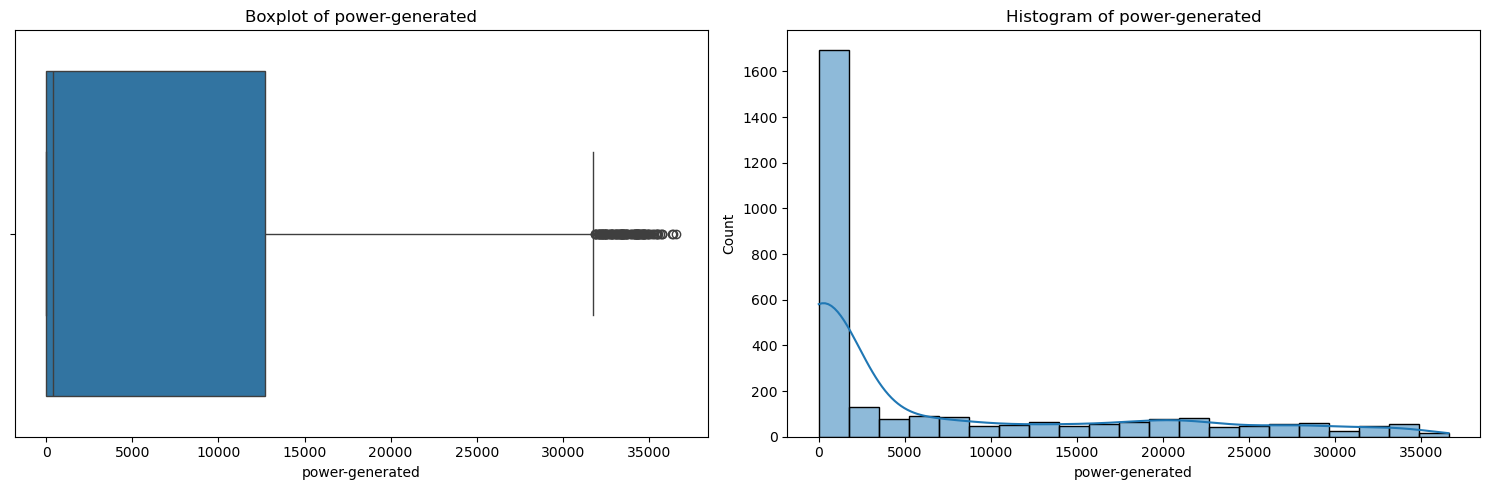

In [9]:
# Visualize distributions and check for outliers using boxplots and histograms

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[0])
    axes[0].set_title(f'Boxplot of {col}')

    # Histogram
    sns.histplot(df[col], kde=True, ax=axes[1])
    axes[1].set_title(f'Histogram of {col}')

    plt.tight_layout()
    plt.show()

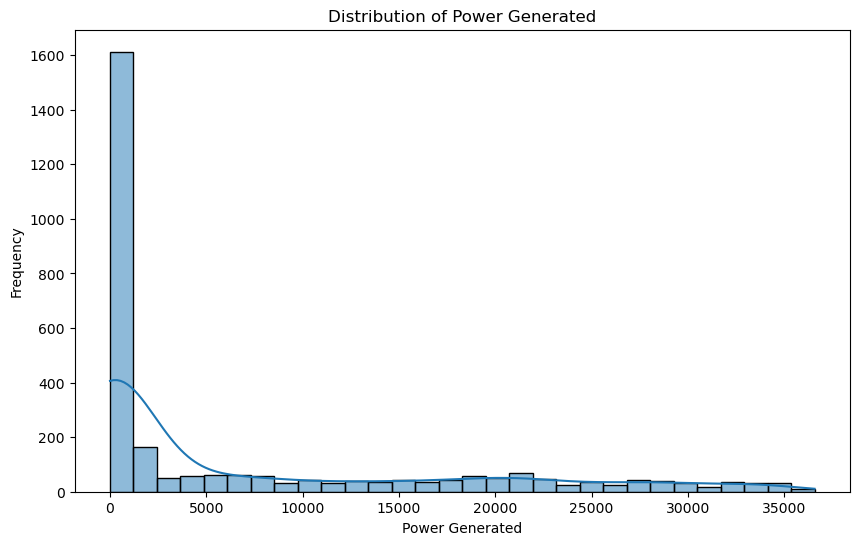

In [10]:
# Analyze the distribution of the target variable 'power-generated'
plt.figure(figsize=(10, 6))
sns.histplot(df['power-generated'], kde=True, bins=30)
plt.title('Distribution of Power Generated')
plt.xlabel('Power Generated')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Detect and remove outliers using IQR
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in numerical_cols:
    # Calculate Q1, Q3, and IQR
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1

    # Define lower and upper bounds
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    # Remove outliers
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Shape after outlier removal:", df.shape)

Shape after outlier removal: (2001, 10)


In [12]:
df

,distance-to-solar-noon,temperature,wind-direction,wind-speed,sky-cover,visibility,humidity,average-wind-speed-(period),average-pressure-(period),power-generated
0,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
6,0.528278,69,28,7.5,0,10.0,36,15.0,29.83,515
...,...,...,...,...,...,...,...,...,...,...
2915,0.166453,63,27,13.9,4,10.0,75,10.0,29.93,6995
2916,0.064020,63,27,13.9,1,10.0,66,15.0,29.91,29490
2917,0.294494,63,27,13.9,2,10.0,68,21.0,29.88,17257
2918,0.524968,63,27,13.9,2,10.0,81,17.0,29.87,677


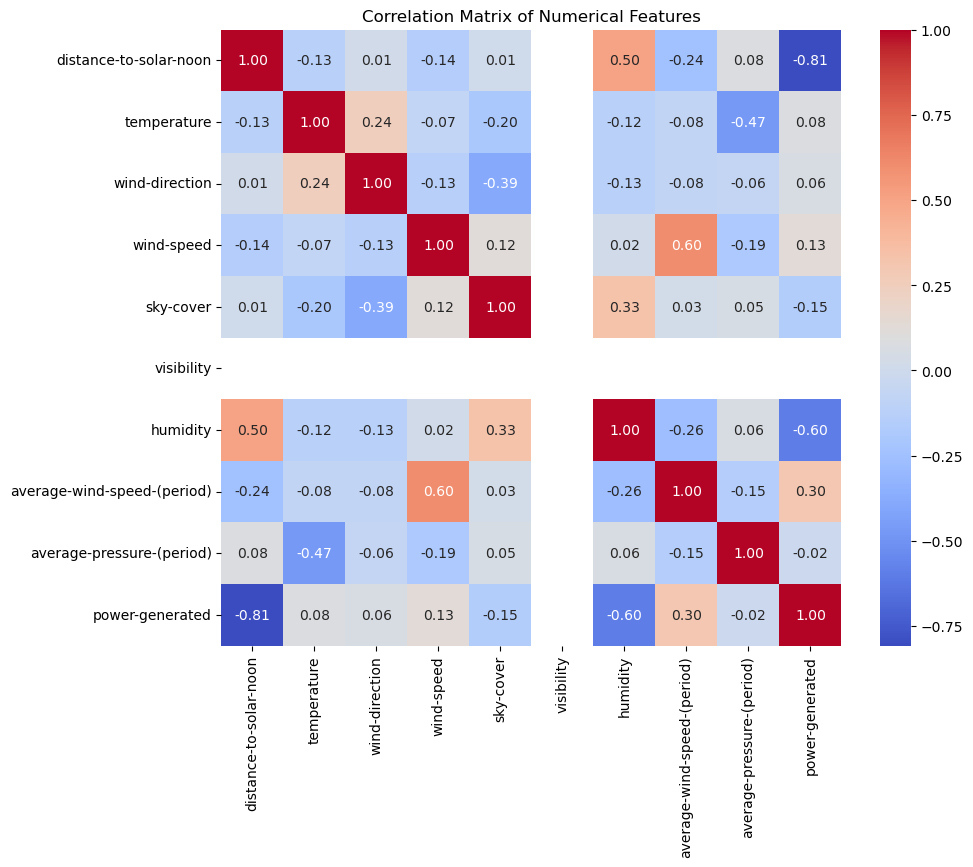

In [13]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

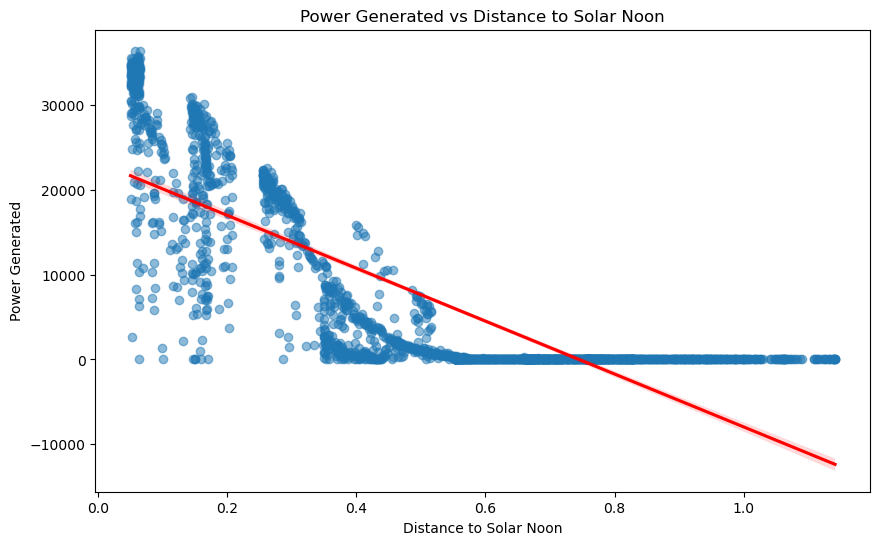

In [14]:
plt.figure(figsize=(10, 6))
sns.regplot(x='distance-to-solar-noon', y='power-generated', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Power Generated vs Distance to Solar Noon')
plt.xlabel('Distance to Solar Noon')
plt.ylabel('Power Generated')
plt.show()

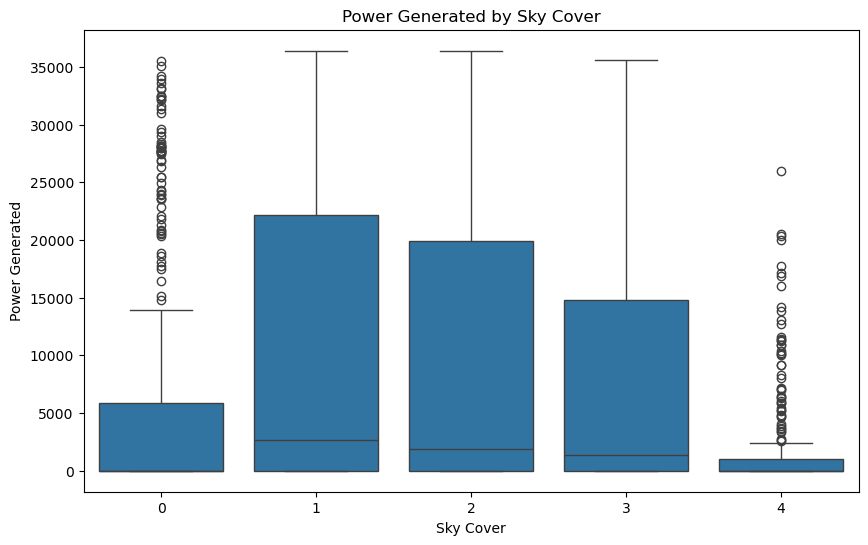

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sky-cover', y='power-generated', data=df)
plt.title('Power Generated by Sky Cover')
plt.xlabel('Sky Cover')
plt.ylabel('Power Generated')
plt.show()

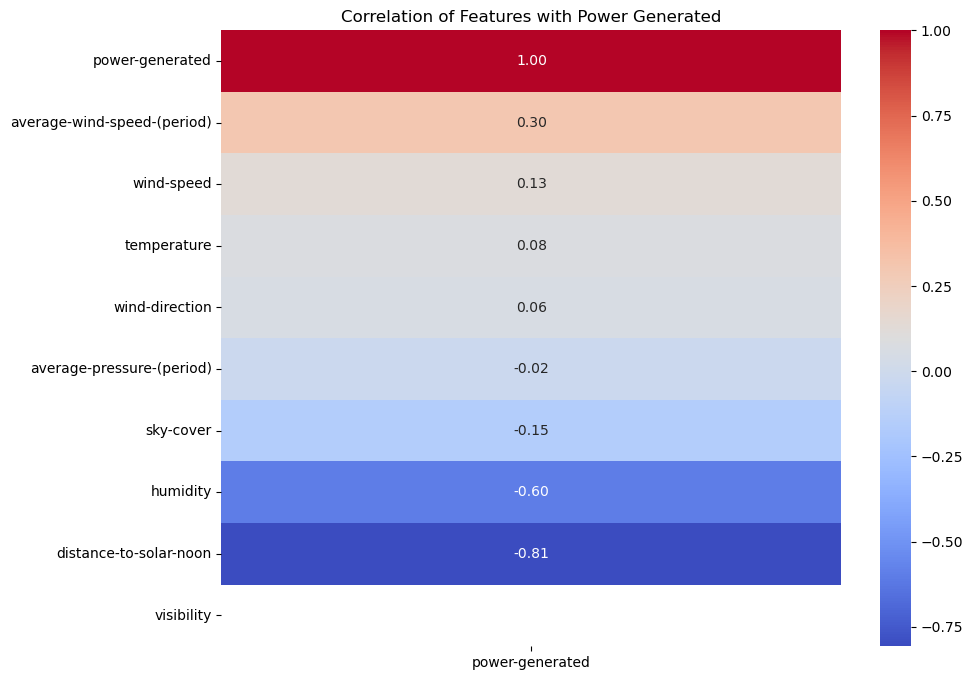

In [16]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['power-generated']].sort_values(by='power-generated', ascending=False), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Features with Power Generated')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop('power-generated', axis=1)
y = df['power-generated']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1600, 9)
Shape of X_test: (401, 9)
Shape of y_train: (1600,)
Shape of y_test: (401,)


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression:")
print(f"  MAE: {lr_mae:.4f}")
print(f"  MSE: {lr_mse:.4f}")
print(f"  R2: {lr_r2:.4f}")

Linear Regression:
  MAE: 5016.8023
  MSE: 36541892.4346
  R2: 0.7016


In [19]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluation
dt_mae = mean_absolute_error(y_test, y_pred_dt)
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_r2 = r2_score(y_test, y_pred_dt)

print("\nDecision Tree Regressor:")
print(f"  MAE: {dt_mae:.4f}")
print(f"  MSE: {dt_mse:.4f}")
print(f"  R2: {dt_r2:.4f}")


Decision Tree Regressor:
  MAE: 1651.7606
  MSE: 15443156.2843
  R2: 0.8739


In [20]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regressor:")
print(f"  MAE: {rf_mae:.4f}")
print(f"  MSE: {rf_mse:.4f}")
print(f"  R2: {rf_r2:.4f}")


Random Forest Regressor:
  MAE: 1372.7148
  MSE: 9945611.7382
  R2: 0.9188


In [21]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regressor
gbm_model = GradientBoostingRegressor(random_state=42)
gbm_model.fit(X_train, y_train)

# Predictions
y_pred_gbm = gbm_model.predict(X_test)

# Evaluation
gbm_mae = mean_absolute_error(y_test, y_pred_gbm)
gbm_mse = mean_squared_error(y_test, y_pred_gbm)
gbm_r2 = r2_score(y_test, y_pred_gbm)

print("\nGradient Boosting Regressor:")
print(f"  MAE: {gbm_mae:.4f}")
print(f"  MSE: {gbm_mse:.4f}")
print(f"  R2: {gbm_r2:.4f}")


Gradient Boosting Regressor:
  MAE: 1480.4758
  MSE: 9206058.9523
  R2: 0.9248


In [22]:
from sklearn.svm import SVR

# Support Vector Regressor
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Predictions
y_pred_svr = svr_model.predict(X_test)

# Evaluation
svr_mae = mean_absolute_error(y_test, y_pred_svr)
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_r2 = r2_score(y_test, y_pred_svr)

print("\nSupport Vector Regressor:")
print(f"  MAE: {svr_mae:.4f}")
print(f"  MSE: {svr_mse:.4f}")
print(f"  R2: {svr_r2:.4f}")


Support Vector Regressor:
  MAE: 7599.2041
  MSE: 173121935.7652
  R2: -0.4135


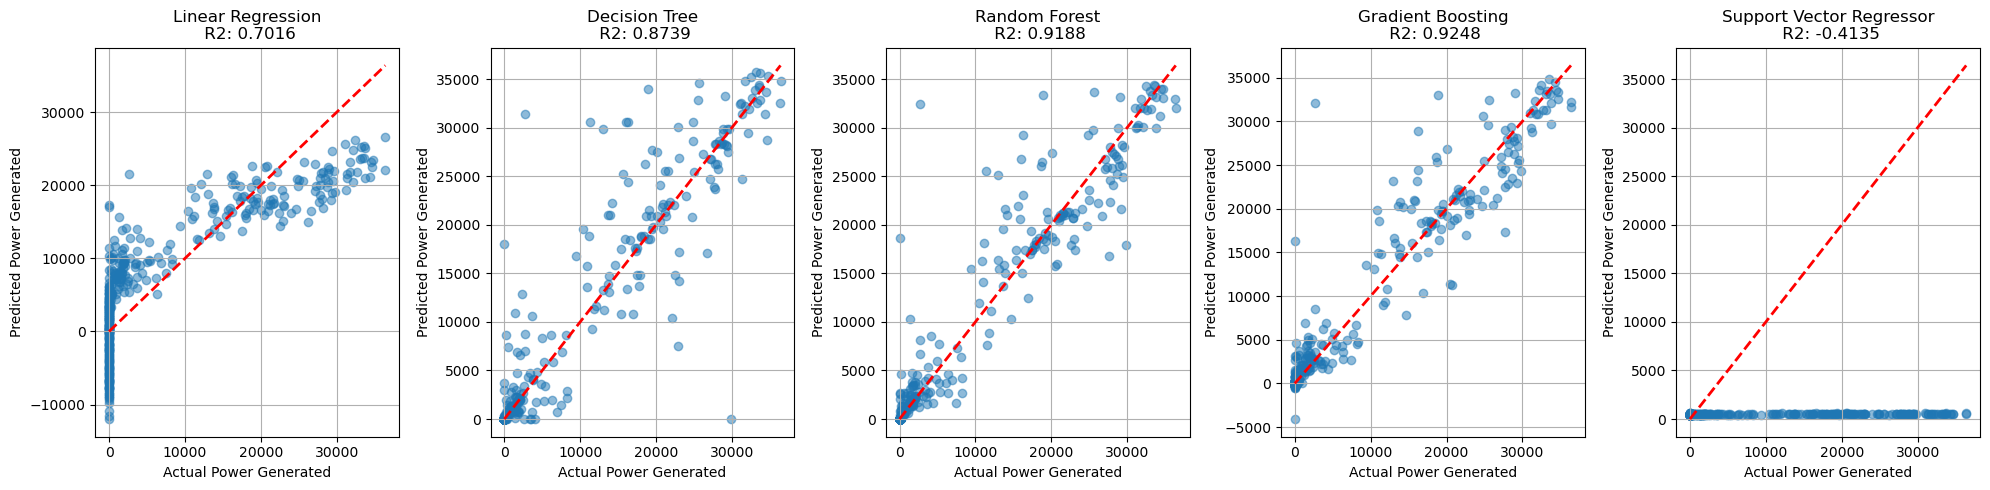

In [23]:
# Visualize predicted vs actual values for each model

models = {
    'Linear Regression': (y_pred_lr, lr_r2),
    'Decision Tree': (y_pred_dt, dt_r2),
    'Random Forest': (y_pred_rf, rf_r2),
    'Gradient Boosting': (y_pred_gbm, gbm_r2),
    'Support Vector Regressor': (y_pred_svr, svr_r2)
}

fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(20, 5))
axes = axes.flatten()

for i, (name, (y_pred, r2)) in enumerate(models.items()):
    axes[i].scatter(y_test, y_pred, alpha=0.5)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal line
    axes[i].set_xlabel('Actual Power Generated')
    axes[i].set_ylabel('Predicted Power Generated')
    axes[i].set_title(f'{name}\n R2: {r2:.4f}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [24]:
results = []

# Re-define the models dictionary with the model objects
models = {
    'Linear Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gbm_model,
    'Support Vector Regressor': svr_model
}

# === Train & Evaluate ===
for name, model in models.items():
    # Re-train the model (though already trained, this ensures the variable is the model object)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print(results_df)

# === Best Model Selection ===
best_model_name = results_df.iloc[0]["Model"]
print(f"\n✅ Best Model: {best_model_name}")

best_model = models[best_model_name]

                      Model        R2          MAE          RMSE
3         Gradient Boosting  0.924832  1480.475771   3034.148802
2             Random Forest  0.918794  1372.714813   3153.666396
1             Decision Tree  0.873906  1651.760599   3929.778147
0         Linear Regression  0.701634  5016.802284   6044.989035
4  Support Vector Regressor -0.413547  7599.204083  13157.580924

✅ Best Model: Gradient Boosting


In [26]:
import joblib
joblib.dump(model, "best_model.pkl")


['best_model.pkl']